# Tutorial: Deep Q-Learning for crypto trading

#### Books & Papers:

- https://arxiv.org/pdf/1708.05866.pdf (A brief survey of deep reinforcement learning)
- http://incompleteideas.net/book/RLbook2020.pdf (Reinforcement Learning, An Introduction)
-https://www.packtpub.com/product/deep-reinforcement-learning-hands-on-second-edition/9781838826994 (Deep Reinforcement Learning Hands-On - Second Edition)
- https://arxiv.org/pdf/1911.10107.pdf (Deep Reinforcement Learning for Trading)
- https://www.sciencedirect.com/science/article/pii/S0957417421000737 (An application of deep reinforcement learning to algorithmic trading)
- https://arxiv.org/abs/1706.10059 (A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem)

#### Links:
- https://github.com/AminHP/gym-anytrading/tree/master
- https://www.kaggle.com/code/learnmore1/deep-reinforcement-learning-for-stock-trading-1#Part-2.-Getting-Started--Load-Python-Packages
- https://medium.com/@murrawang/deep-q-network-and-its-application-in-algorithmic-trading-16440a112e04

In [1]:
# Install useful Python libraries.

!pip install yfinance --upgrade --no-cache-dir

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# Import useful Python libraries.

from collections import deque
import random
import time
import calendar
import datetime
from datetime import date, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader import data as pdr
import yfinance as yf
import ccxt
import mplfinance as mpf

import tensorflow.compat.v1 as tf

In [3]:
sns.set()
tf.compat.v1.disable_eager_execution()

In [4]:
# A possible solution to access financial data (crypto data).

sdate_training = date(2024,1,1)   # Start date training data -> included.
edate_training = date(2024,1,15)   # End date training data - excluded.

sdate_test = date(2024,1,15)   # Start date training date -> included.
edate_test = date(2024,1,20)   # End date training date - excluded.

trading_symbol = 'BTC/USDT' # Pair to be downloaded (BE CAREFUL).
granularity = '1h' # Data granularity (it changes based on the chosen Exchange). 

In [5]:
list_dates_training = pd.date_range(sdate_training, edate_training-timedelta(days=1),freq='d').strftime("%Y-%m-%d").tolist() # List of all days in the training set.
list_dates_test = pd.date_range(sdate_test, edate_test-timedelta(days=1),freq='d').strftime("%Y-%m-%d").tolist() # List of all days in the test set.

In [6]:
print(f'Training days: {list_dates_training}')

Training days: ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14']


In [7]:
print(f'Test days: {list_dates_test}')

Test days: ['2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19']


In [8]:
import ccxt
import pandas as pd
import datetime
import time

# Assuming list_dates_training and list_dates_test are defined, as well as trading_symbol and granularity
exchange = ccxt.binance()

# Prepare empty DataFrames
df_training = pd.DataFrame(columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
df_test = pd.DataFrame(columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Function to download data
def download_data(list_dates, trading_symbol, granularity):
    df_list = []  # To collect dataframes temporarily
    for date in list_dates:
        since = time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()) * 1000
        ohlcv = exchange.fetch_ohlcv(symbol=trading_symbol, timeframe=granularity, since=int(since))
        df = pd.DataFrame(ohlcv, columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')
        df = df.iloc[:24]  # Assuming you want the first 24 records of each fetched batch
        df_list.append(df)
    full_df = pd.concat(df_list, ignore_index=True)
    full_df.set_index('Time', inplace=True)
    return full_df

# Download training and test data
df_training = download_data(list_dates_training, trading_symbol, granularity)
df_test = download_data(list_dates_test, trading_symbol, granularity)


In [9]:
print(f'Available time granularities on the chosen Exchange: {exchange.timeframes}')

Available time granularities on the chosen Exchange: {'1s': '1s', '1m': '1m', '3m': '3m', '5m': '5m', '15m': '15m', '30m': '30m', '1h': '1h', '2h': '2h', '4h': '4h', '6h': '6h', '8h': '8h', '12h': '12h', '1d': '1d', '3d': '3d', '1w': '1w', '1M': '1M'}


In [10]:
df_training.head(3) # Visualize the training dataset.

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-01 00:00:00,42283.58,42554.57,42261.02,42475.23,1271.68108
2024-01-01 01:00:00,42475.23,42775.00,42431.65,42613.56,1196.37856
2024-01-01 02:00:00,42613.57,42638.41,42500.00,42581.10,685.21980


In [11]:
df_test.head(3) # Visualize the test dataset.

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-15 00:00:00,41732.35,42353.94,41718.05,42279.75,2433.52283
2024-01-15 01:00:00,42279.76,42398.73,42176.28,42275.18,1404.64040
2024-01-15 02:00:00,42275.17,42411.62,42194.12,42399.72,850.09544


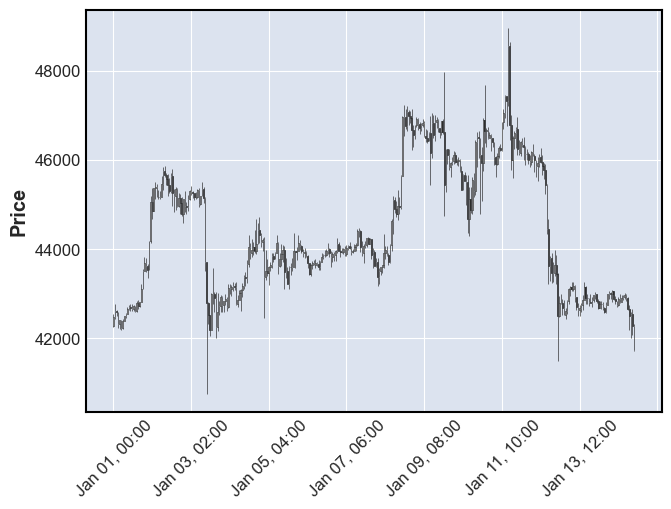

In [12]:
mpf.plot(df_training,type='candle') # A way to visualize data using candles. 

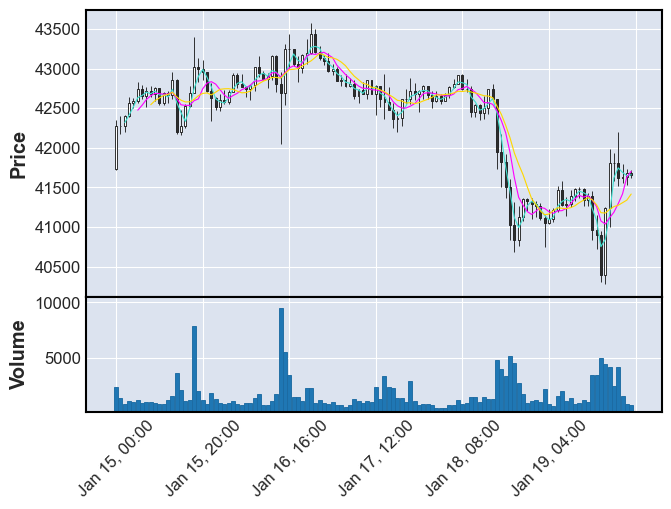

In [13]:
mpf.plot(df_test,type='candle',mav=(3,6,9),volume=True) # Multiple MAVs visualization.

### Reinforcement Learning

In [14]:
df = df_training.copy()
name = 'SimplisticDeepQTrader'

In [15]:
class Trader:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2 # Round the result down to the nearest whole number.
        self.trend = trend
        self.skip = skip
        self.action_size = 3 # Action 0 -> Hold; Action 1 -> Buy; Action 2 -> Sell.
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        
        # Reset the TensorFlow default graph to clear any existing tensors and operations.
        tf.reset_default_graph()

        # Create an interactive TensorFlow session.
        self.sess = tf.InteractiveSession()

        # Create a TensorFlow placeholder for the input state of the network.
        # The first dimension of the placeholder is "None", which means it can take any batch size.
        # The second dimension is the size of the state vector.
        self.X = tf.placeholder(tf.float32, [None, self.state_size])

        # Create a TensorFlow placeholder for the output action of the network.
        # The first dimension of the placeholder is "None", which means it can take any batch size.
        # The second dimension is the size of the action vector.
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])

        # Create a fully connected layer with 256 units and ReLU activation function.
        # The input to this layer is the state vector.
        # The output is the hidden layer output.
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)

        # Create a fully connected layer with size equal to the action vector size.
        # The input to this layer is the hidden layer output.
        # The output is the output of the network.
        self.logits = tf.layers.dense(feed, self.action_size)

        # Compute the mean squared error between the output of the network and the target action.
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))

        # Create a gradient descent optimizer with a learning rate of 1e-5.
        # Minimize the cost using the optimizer.
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(self.cost)

        # Initialize all variables in the TensorFlow graph.
        self.sess.run(tf.global_variables_initializer())

        
    def act(self, state):
        """
        Selects an action to take given a state.

        Args:
        state: The state of the environment.

        Returns:
        The action to take (an integer).
        """
        
        # If a random number is less than the exploration rate, select a random action.
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        # Otherwise, given the current state, use the neural network to select the action with the highest probability.
        # The action with the highest probability is the one with the highest output value from the logits layer.
        return np.argmax(self.sess.run(self.logits, feed_dict = {self.X: state})[0])

    
    def get_state(self, t):
        """
        Computes the state of the agent at time 't'.

        Args:
        - t (int): The current time index.

        Returns:
        - numpy array: A numpy array of shape (1, window_size-1) representing the state of the agent. Each element in the 
                      array represents the difference between the i-th and (i+1)-th prices in the stock prices window.
                      The window size is defined by 'window_size' attribute of the class.
        """
        
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]

        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        
        return np.array([res])

    
    def replay(self, batch_size):
        """
        Performs replay to train a Q-learning trading agent's neural network. It improves the agent's decision-making 
        by learning from past experiences (transitions) stored in memory.

        Process:
        1. Creates a mini batch of the most recent 'batch_size' transitions from the agent's memory.
        2. Prepares arrays for states (X) and target Q-values (Y), and calculates Q-values for current and next states.
        3. Updates the target Q-values for each transition in the mini batch using the Bellman equation. This update 
           depends on the reward and the maximum Q-value of the next state, applicable if the episode is not done.
        4. Trains the neural network using the states and updated target Q-values.
        5. Decays the exploration rate if above a certain threshold.

        Args:
        - batch_size: Number of transitions to sample from the agent's memory.

        Returns:
        - cost: Measure of the neural network's performance during training.
        """

        mini_batch = []
        l = len(self.memory)

        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])

        replay_size = len(mini_batch)

        # Create empty arrays to hold the state and target data
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))

        # Extract the states and next states from the mini batch
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])

        # Obtain Q values for the current and next states
        Q = self.sess.run(self.logits, feed_dict={self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict={self.X: new_states})

        # Loop through the mini batch and update the target Q values
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward

            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])

            X[i] = state
            Y[i] = target

        # Train the neural network on the state and target data
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X: X, self.Y: Y})

        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Return the cost of the neural network during training
        return cost
    
    def train(self, iterations, checkpoint, initial_money):
        """
        The function train takes three arguments: iterations (the number of iterations to train the agent), 
        checkpoint (the interval at which to print the training progress), and initial_money 
        (the amount of money to start with). The function trains the RL agent with a replay buffer for the 
        specified number of iterations. At each iteration, the function initializes variables for the current 
        episode, iterates over the time steps in the trend data, takes an action based on the current state, 
        updates the state for the next step, and adds the current step to the replay buffer. 
        If the current iteration is a multiple of the checkpoint interval, the function prints the 
        training progress. The function does not return anything.

        Args:
        - self: an instance of the RL agent class
        - iterations (int): the number of iterations to train the agent
        - checkpoint (int): the interval at which to print the training progress
        - initial_money (float): the amount of money to start with

        Returns: None
        """
        for i in range(iterations):
            # Initialize variables for the current episode
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money

            # Iterate over the time steps in the trend data
            for t in range(0, len(self.trend) - 1, self.skip):
                # Take an action based on the current state
                action = self.act(state)
                # Get the next state
                next_state = self.get_state(t + 1)

                # If the action is "buy" and there is enough money to buy, add to inventory
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                # If the action is "sell" and there is inventory to sell, sell at current price
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                # Calculate the investment return and add the current step to the replay buffer
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))

                # Update the state for the next step and replay the buffer
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)

            # Print the progress at the checkpoint interval
            if (i+1) % checkpoint == 0:
                print(f'Epoch: {i+1} | Total rewards: {total_profit} | Cost: {cost} | Total money {starting_money}')
                
                
    def test(self, initial_money, trend):
        """
        Test the trained RL agent on the provided trend data and initial money.

        Args:
        - initial_money (float): the amount of money to start with
        - trend (list): the list of stock prices to test on

        Returns:
        - states_buy (list): the indices of the hours when the agent bought stocks
        - states_sell (list): the indices of the hours when the agent sold stocks
        - total_gains (float): the total profit made by the agent
        - invest (float): the percentage of profit made by the agent
        """
        # Set the trend data and initial money
        self.trend = trend
        starting_money = initial_money

        # Initialize variables for tracking state and actions
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)

        # Loop through the trend data and take actions based on the agent's policy
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            # Buy stocks if action is 1 and there is enough money
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print(f'Hour {t}: buy 1 unit at price {self.trend[t]}, total balance {initial_money}')

            # Sell stocks if action is 2 and there are stocks in inventory
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(f'Hour {t}: sell 1 unit at price {self.trend[t]}, investment {invest}, total balance {initial_money}')

            state = next_state

        # Calculate and return the final results
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [16]:
close_training = df_training.Close.values.tolist() # Get closing prices.
close_test = df_test.Close.values.tolist() # Get closing prices.

initial_money = 100000 # Initial amount of money.
window_size = 5 # Lookback window (it contributes to the state's definition).
skip = 1 # Overlap regulator.
batch_size = 64

agent = Trader(state_size = window_size, 
               window_size = window_size, 
               trend = close_training, 
               skip = skip, 
               batch_size = batch_size)

agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\lyakh\AppData\Local\Temp\ipykernel_31584\3060502780.py:38: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_31584\3060502780.py:43: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


Epoch: 10 | Total rewards: -683.7399999999689 | Cost: 0.4189753532409668 | Total money 56808.34000000004
Epoch: 20 | Total rewards: -1999.82999999998 | Cost: 0.11087080091238022 | Total money 55492.2500000001
Epoch: 30 | Total rewards: -2384.9899999999907 | Cost: 0.11668925732374191 | Total money 55107.09000000001
Epoch: 40 | Total rewards: -1071.7899999999718 | Cost: 0.043798815459012985 | Total money 56420.29000000005
Epoch: 50 | Total rewards: 267.1000000000204 | Cost: 0.031995754688978195 | Total money 57759.180000000095
Epoch: 60 | Total rewards: 1901.5600000000122 | Cost: 0.03396350145339966 | Total money 59393.64000000009
Epoch: 70 | Total rewards: 2784.4000000000233 | Cost: 0.10169050097465515 | Total money 102784.40000000008
Epoch: 80 | Total rewards: -351.0799999999872 | Cost: 0.02256825566291809 | Total money 57141.000000000015
Epoch: 90 | Total rewards: 1024.0100000000093 | Cost: 0.06411008536815643 | Total money 101024.01000000001
Epoch: 100 | Total rewards: 3219.770000000

In [17]:
states_buy, states_sell, total_gains, invest = agent.test(initial_money = initial_money, trend=close_test)

Hour 17: buy 1 unit at price 42696.58, total balance 57303.42
Hour 18: buy 1 unit at price 43015.82, total balance 14287.599999999999
Hour 20: sell 1 unit at price 42960.0, investment 0, total balance 57247.6
Hour 21: sell 1 unit at price 42716.0, investment 0, total balance 99963.6
Hour 31: buy 1 unit at price 42791.13, total balance 57172.47000000001
Hour 34: buy 1 unit at price 42872.0, total balance 14300.470000000008
Hour 37: sell 1 unit at price 42805.83, investment 0, total balance 57106.30000000001
Hour 38: buy 1 unit at price 42690.0, total balance 14416.30000000001
Hour 40: sell 1 unit at price 43249.72, investment 0, total balance 57666.02000000001
Hour 41: sell 1 unit at price 43051.74, investment 0, total balance 100717.76000000001
Hour 43: buy 1 unit at price 43166.11, total balance 57551.65000000001
Hour 47: sell 1 unit at price 43137.95, investment 0, total balance 100689.6
Hour 50: buy 1 unit at price 42997.25, total balance 57692.350000000006
Hour 52: sell 1 unit at p

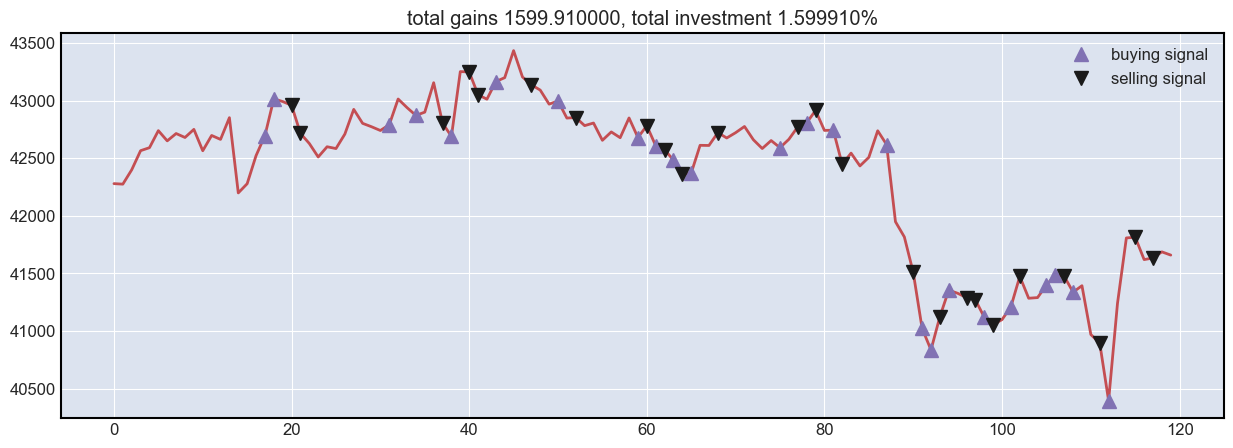

In [18]:
fig = plt.figure(figsize = (15,5))
plt.plot(close_test, color='r', lw=2.)
plt.plot(close_test, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close_test, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()